# XGBoost full model
(using stratified 5-fold cross validation)

### Plain English summary


### Model and data

### Aims

### Observations

Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb
and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb


## Import libraries

In [26]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [27]:
start_time = time.time()

## Set up paths and filenames

In [28]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
    data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/kfold_5fold'
#    data_read_filename: str = '03_reformatted_data_ml.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    model_text: str = 'xgb_full_model'
    notebook: str = '03_'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [29]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(paths.data_read_path + '/03_train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(paths.data_read_path + '/03_test_{0}.csv'.format(i)))

Get list of features

In [30]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 51 features


## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [31]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [32]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [33]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k_fold in range(5):
        train_data[k_fold] = convert_feature_to_one_hot(train_data[k_fold], feature, prefix)
        test_data[k_fold] = convert_feature_to_one_hot(test_data[k_fold], feature, prefix)

Each train and test set not necessarily have all columns.
Check if each train and test dataset contains each category.

In [34]:
set_one_hot_features = set()
for k_fold in range(5):
    temp_set = set(train_data[k_fold].columns).union(set(test_data[k_fold].columns))
    set_one_hot_features = set_one_hot_features.union(temp_set)

Print if any columns are missing.

In [35]:
for k_fold in range(5):
    if len(list(set_one_hot_features - set(train_data[k_fold].columns))) > 0:
        print(f"Train kfold {k_fold}: {set_one_hot_features - set(train_data[k_fold].columns)}")
    if len(list(set_one_hot_features - set(test_data[k_fold].columns))) > 0:
        print(f"Test kfold {k_fold}: {set_one_hot_features - set(test_data[k_fold].columns)}")

Feature names with one hot encoding

In [36]:
features_ohe = list(train_data[0])

# Remove 'id'
features_ohe = features_ohe[1:]

print(f"There are {len(features_ohe)} features")

There are 51 features


## Fit XGBoost model

Train model with all features (same as used in notebook 02_xgb_feature_selection.ipynb for comparison with the feature selection models)

In [37]:
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    model_kfold.append(model)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_kfold):0.3f})')

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(error_within_one_kfold):0.3f})')

All features, AUC: 0.813 (std across 5 kfolds: 0.002)
All features, accuracy: 0.437 (std across 5 kfolds: 0.003)
All features, accuracy within one: 0.754 (std across 5 kfolds: 0.002)


## Feature Importances
Get XGBoost feature importances (average across k-fold results)

In [46]:
# Feature names
#feature_names = X_test_kfold[0].columns.values

# Get average feature importance from k-fold
importances = np.array(feature_importance_kfold).mean(axis = 0)

# Store in DataFrame
feature_importance_df = pd.DataFrame(data = importances, index=features_ohe)#feature_names)
feature_importance_df.columns = ['importance']

# Sort by importance (weight)
feature_importance_df.sort_values(by='importance', 
                                  ascending=False, inplace=True)

# Save
#feature_importance_df.to_csv(f'output/{notebook}_{model_type}_feature_importance.csv')

# Display top 25
feature_importance_df.head(25)

,importance
stroke_severity,0.052283
nihss_complete,0.027296
team_Royal Stoke University Hospital,0.017819
team_Salford Royal Hospital,0.014653
nihss_arrival_loc_questions,0.014203
team_University Hospital Coventry,0.014063
team_University Hospital of North Durham,0.012669
team_Leicester Royal Infirmary,0.012428
team_Derriford Hospital,0.012403
team_Blackpool Victoria Hospital,0.012039



Create a bar chart for the XGBoost feature importance values

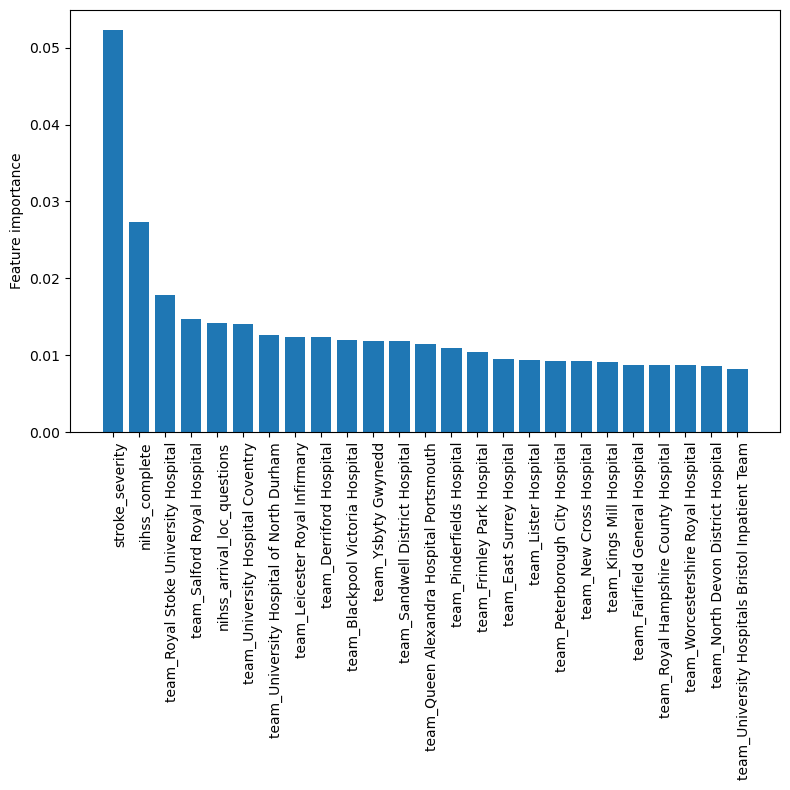

In [47]:

# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = feature_importance_df.index.values[0:25]
pos = np.arange(len(labels))
val = feature_importance_df['importance'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature importance')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
#plt.savefig(f'output/{notebook}_{model_type}_feature_weights_bar.jpg', dpi=300)
plt.show()

## SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

## Get SHAP values
TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [51]:
# Initialise empty lists
shap_values_extended_kfold = []
shap_values_kfold = []

# For each k-fold split
for k in range(5):
    # Set filename
    filename = (f'{paths.data_save_path}{paths.notebook}{paths.model_text}_shap_values_extended_{k}.p')
    # Check if exists
    file_exists = exists(filename)
    
    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values_extended_kfold.append(shap_values_extended)
            shap_values_kfold.append(shap_values_extended.values)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model_kfold[k], X_train[k])

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test[k])
        shap_values_extended_kfold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_kfold.append(shap_values)        

        explainer_filename = (f'{paths.data_save_path}{paths.notebook}_{paths.model_text}_shap_explainer_{k}.p')

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
        # Print progress
        print (f'Completed {k+1} of 5')

KeyError: 0

Calibration and assessment of accuracy when model has high confidence

In [ ]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for k in range(5):
    
    # Get observed class and predicted probability
    observed = y_test[k]
    probability = y_probs_kfold[k]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(probability, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = probability
    reliability['observed'] = observed
    classification = 1 * (probability > 0.5 )
    reliability['correct'] = observed == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = k

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)


## Get average SHAP values for each k-fold
For each k-fold split, calculate the mean SHAP value for each feature (across all instances). The mean is calculated in three ways:

mean of raw values
mean of absolute values
absolute of mean of raw values

In [ ]:
# Initialise empty lists
shap_values_mean_kfold = []

# For each k-fold split
for k in range(5):
    # Calculate mean SHAP value for each feature (across all instances)
    shap_values = shap_values_kfold[k]
    df = pd.DataFrame(index=features_ohe)
    df['mean_shap'] = np.mean(shap_values, axis=0)
    df['abs_mean_shap'] = np.abs(df['mean_shap'])
    df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    df['rank'] = df['mean_abs_shap'].rank(
        ascending=False).values
    df.sort_index()
    shap_values_mean_kfold.append(df)

## Examine consistency of SHAP values across k-fold splits
A model is fitted to each k-fold split, and SHAP values are obtained for each model. This next section assesses the range of SHAP values (mean |SHAP|) for each feature across the k-fold splits.

In [ ]:
# Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
df_mean_abs_shap = pd.DataFrame()

# For each k-fold split
for k in range(5):
    # mean of the absolute SHAP values for each k-fold split
    df_mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']

In [ ]:
df_mean_abs_shap


Create (and show) a dataframe that stores the min, median, and max SHAP values for each feature across the 5 k-fold splits

In [ ]:
df_mean_abs_shap_summary = pd.DataFrame()
df_mean_abs_shap_summary['min'] = df_mean_abs_shap.min(axis=1)
df_mean_abs_shap_summary['median'] = df_mean_abs_shap.median(axis=1) 
df_mean_abs_shap_summary['max'] = df_mean_abs_shap.max(axis=1)
df_mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [ ]:

df_mean_abs_shap_summary

Identify the 10 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values)

In [ ]:
top_10_shap = list(df_mean_abs_shap_summary.head(10).index)

Create a violin plot for these 10 features with the highest SHAP values.

A violin plot shows the distribution of the SHAP values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

In [ ]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_mean_abs_shap.loc[top_10_shap].T,
               showmedians=True,
               widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('|SHAP value| (log odds)')


filename = (f'{paths.data_save_path}{paths.notebook}_{paths.model_text}_shap_violin.jpg')

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Examine the consitency of feature importances across k-fold splits
XGBoost algorithm provides a metrc per feature called "feature importance".

A model is fitted to each k-fold split, and feature importance values are obtained for each model. This next section assesses the range of feature importance values for each feature across the k-fold splits.

In [ ]:

# Initialise DataFrame (stores feature importance values for each kfold)
df_feature_importance = pd.DataFrame()

# For each k-fold
for k in range(5):
    # feature importance value for each k-fold split
    df_feature_importance[f'{k}'] = feature_importance_kfold[k]['importance']

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [ ]:
df_feature_importance_summary = pd.DataFrame()
df_feature_importance_summary['min'] = df_feature_importance.min(axis=1)
df_feature_importance_summary['median'] = df_feature_importance.median(axis=1) 
df_feature_importance_summary['max'] = df_feature_importance.max(axis=1)
df_feature_importance_summary.sort_values('median', inplace=True, 
                                          ascending=False)

In [ ]:
df_feature_importance_summary

Identify the 10 features with the highest feature importance values.

In [ ]:
top_10_importances = list(df_feature_importance_summary.head(10).index)

Create a violin plot for these 10 features with the highest feature importance values.

A violin plot shows the distribution of the feature importance values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

In [ ]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_feature_importance_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')

filename = (f'{paths.data_save_path}{paths.notebook}_{paths.model_text}_importance_violin.jpg')

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Compare top 10 SHAP and feature importance values
Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values

In [ ]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['SHAP (feature name)'] = \
                            df_mean_abs_shap_summary.index
df_compare_shap_importance['SHAP (median value)']  = \
                            df_mean_abs_shap_summary['median'].values
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance_summary.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance_summary['median'].values
df_compare_shap_importance.head(10)

Plot all of the features, showing feature importance vs SHAP values.

In [ ]:
df_shap_importance = pd.DataFrame()
df_shap_importance['Shap'] = df_mean_abs_shap_summary['median']
df_shap_importance = df_shap_importance.merge(
    df_feature_importance_summary['median'], left_index=True, right_index=True)
df_shap_importance.rename(columns={'median':'Importance'}, inplace=True)
df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(df_shap_importance['Shap'],
            df_shap_importance['Importance'])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
ax1.set_ylabel('Importance values (median of the k-folds)')
ax1.grid()

filename = (f'{paths.data_save_path}{paths.notebook}_{paths.model_text}_shap_importance_correlation.jpg')
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
reliability_summary

Plot results:

In [ ]:
fig = plt.figure(figsize=(10,5))

# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax3 = ax2.twinx()  
for k in range(5):
    mask = reliability_collated['k-fold'] == k
    result_kfold = reliability_collated[mask]
    x = result_kfold['confidence']
    y = result_kfold['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

#plt.savefig(f'./output/{notebook}_{model_type}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [ ]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

In [ ]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')